### This Machine Learning model trains on Yahoo Finance historical data (features) to predict a future target stock price (label).

In [495]:
#### LIBRARIES ### 
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import matplotlib.pyplot as plt
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Activation, Dropout
from keras import regularizers
import yfinance as yf

### FUNCTIONS ###
# convert series to supervised learning (credit: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


## FETCH DATA

In [530]:
# Define the ticker symbols for features and labels
tickers = ["AAPL", "MSFT",'HG=F', 'CL=F', 'NG=F', '^VIX', 'BTC-USD'] #features
target = 'BTC-USD'
target_label = 'Open'

#time period of historical data to fetch
start = "2000-01-01"
end = "2023-09-01"

n_train_days = 365  #size in days of train/test data (i.e. model is tested on last 365 days, and trained on previous days.)
nb_timesteps = 5 #number of timesteps to shift lag (t-3, t-2, t-1, t) for 3 timesteps)

# Fetch historical data for tickers and builds and cleans a Pandas Dataframe
mydf = pd.DataFrame()
for ticker in tickers:
    stock = yf.download(ticker, start, end)
    data[ticker]= stock
    mydf = pd.concat([mydf, stock['Adj Close']], axis=1, join='outer')
    mydf = pd.concat([mydf, stock['Volume']], axis=1, join='outer')
    stock['Range'] = stock['High'] - stock['Low'] #calculate intraday range
    mydf = pd.concat([mydf, stock['Range']], axis=1, join='outer')
    mydf=mydf.rename(columns={'Adj Close': ticker + " Adj Close", 'Volume' : ticker + ' Volume', 'Range' : ticker + ' Intraday Range'})
label = yf.download(target, start, end)
mydf = pd.concat([mydf, label[target_label]], axis=1, join='outer')
mydf=mydf.rename(columns={target_label: target + ' ' + target_label})
mydf.dropna(inplace=True) #drops days where data is not available for all tickers
mydf = mydf.loc[:, (mydf != 0).any(axis=0)] #drops columns with all zeros
print(mydf.columns) #Prints columns of the data used for training, last column is target

#normalizing and scaling data
dataset = pd.DataFrame(mydf)
nb_features = dataset.shape[1]-1 #(FEATURES --> 'volume', 'open', 'close', etc. However, 7th entry 'price' is a LABEL.)
values = dataset.values #values method give numpy objects instead of df object

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, nb_timesteps, 1) #(data, number of timesteps t to shift lag, number of timesteps to lead )

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-x for x in range(nb_features,0,-1)]], axis=1, inplace=True) #drops multivariate features from dataset and leaves only 'price' to be forecasted 


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Index(['AAPL Adj Close', 'AAPL Volume', 'AAPL Intraday Range',
       'MSFT Adj Close', 'MSFT Volume', 'MSFT Intraday Range',
       'HG=F Adj Close', 'HG=F Volume', 'HG=F Intraday Range',
       'CL=F Adj Close', 'CL=F Volume', 'CL=F Intraday Range',
       'NG=F Adj Close', 'NG=F Volume', 'NG=F Intraday Range',
       '^VIX Adj Close', '^VIX Intraday Range', 'BTC-USD Adj Close',
       'BTC-USD Volume', 'BTC-USD Intraday Range', 'BTC-USD Open'],
      dtype='object')


,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),...,var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var1(t)
5,0.010480,0.343795,0.012436,0.015608,0.158313,0.006990,0.402074,0.002808,0.060000,0.818509,...,0.284704,0.166077,0.021345,0.078722,0.030424,0.003824,0.000106,0.003435,0.003343,0.010696
6,0.010747,0.190712,0.004145,0.016034,0.144190,0.003290,0.385683,0.002506,0.102857,0.810141,...,0.296292,0.114777,0.032988,0.056152,0.051431,0.003637,0.000065,0.001073,0.003842,0.005760
7,0.009691,0.408430,0.025069,0.018269,1.000000,0.027961,0.384345,0.002833,0.067143,0.806050,...,0.303611,0.175705,0.041074,0.088375,0.086563,0.003465,0.000054,0.001001,0.003655,0.009424
8,0.009818,0.291067,0.019345,0.017045,0.160231,0.004523,0.367453,0.004697,0.084286,0.800533,...,0.305196,0.218961,0.017141,0.077634,0.050706,0.003358,0.000039,0.001069,0.003481,0.008610
9,0.011828,0.359836,0.035926,0.015715,0.133291,0.009046,0.366282,0.003022,0.070000,0.800781,...,0.325933,0.281499,0.041074,0.092998,0.049258,0.002929,0.000070,0.000917,0.002969,0.009424


In [505]:
### RESHAPE DATA ### 

# split into train and test sets
values = reframed.values
train = values[:-n_train_days, :]
test = values[-n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print('The following shapes show the size of the train and test data:')
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1882, 1, 105) (1882,) (365, 1, 105) (365,)


/Users/jonwicklund/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/keras/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
79/79 - 16s - 205ms/step - loss: 0.0666 - val_loss: 0.1751
Epoch 2/300
79/79 - 1s - 6ms/step - loss: 0.1043 - val_loss: 0.1106
Epoch 3/300
79/79 - 1s - 6ms/step - loss: 0.0727 - val_loss: 0.0929
Epoch 4/300
79/79 - 1s - 10ms/step - loss: 0.0489 - val_loss: 0.0921
Epoch 5/300
79/79 - 1s - 7ms/step - loss: 0.0402 - val_loss: 0.0615
Epoch 6/300
79/79 - 1s - 13ms/step - loss: 0.0387 - val_loss: 0.0617
Epoch 7/300
79/79 - 0s - 6ms/step - loss: 0.0339 - val_loss: 0.0671
Epoch 8/300
79/79 - 0s - 6ms/step - loss: 0.0395 - val_loss: 0.0637
Epoch 9/300
79/79 - 0s - 6ms/step - loss: 0.0320 - val_loss: 0.0520
Epoch 10/300
79/79 - 0s - 5ms/step - loss: 0.0307 - val_loss: 0.0513
Epoch 11/300
79/79 - 0s - 5ms/step - loss: 0.0356 - val_loss: 0.0500
Epoch 12/300
79/79 - 0s - 5ms/step - loss: 0.0321 - val_loss: 0.0516
Epoch 13/300
79/79 - 0s - 6ms/step - loss: 0.0303 - val_loss: 0.0640
Epoch 14/300
79/79 - 0s - 6ms/step - loss: 0.0301 - val_loss: 0.0520
Epoch 15/300
79/79 - 0s - 5ms/step - l

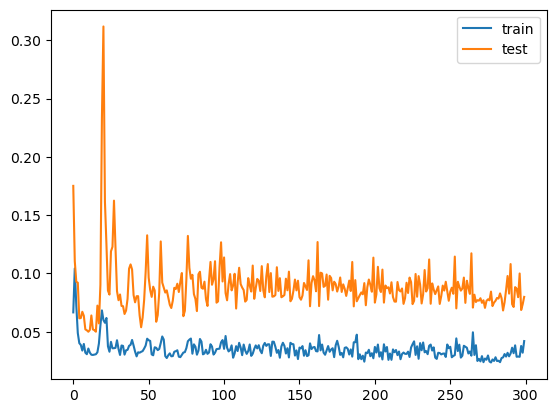

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


In [506]:
# DESIGN NEURAL NETWORK MODEL 

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(120, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=24, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


Test RMSE: 15.026


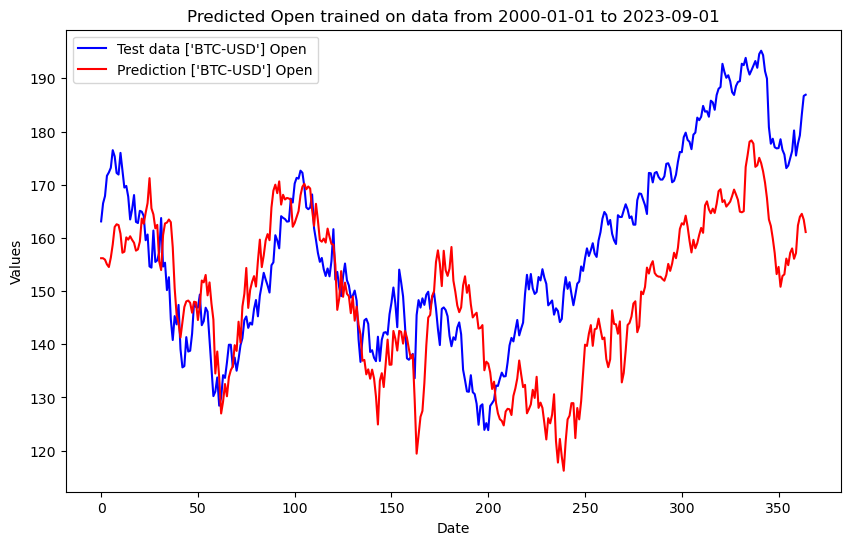

In [524]:
# To use inverse_transform, you need to reshape lstm_output_scaled to match feature space
# Here we create a dummy array with original feature space

zeros= (np.squeeze(yhat).shape[0],dataset.values.shape[1]-1)
dummy_input = np.hstack((yhat[:,:,0], np.zeros(zeros))) #note, np.hstack takes TUPLE, and, :,:,0 gives 2D which is needed.
# Reverse the scaling on dummy_input
dummy_input2 = np.hstack((test_y.reshape(-1, 1), np.zeros(zeros))) #note, -1,reshape makes it into 2D which is needed!
original_y = scaler.inverse_transform(dummy_input)[:, 0]  # Extract only the original label
original_test = scaler.inverse_transform(dummy_input2)[:, 0]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the first time series
ax.plot(original_test, label=f'Test data {target} {target_label}', color='blue')

# Plot the second time series
ax.plot(original_y, label=f'Prediction {target} {target_label}', color='red')

# Customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.set_title(f'Predicted {target_label} trained on data from {start} to {end}')
ax.legend()

rmse = sqrt(mean_squared_error(original_test, original_y))
print('Test RMSE: %.3f' % rmse)
# Show the plot
plt.show()

## OLD BELOW  - and neat code tricks

In [ ]:
AAPL=train_test(df,0.98) #splits AAPL data in training and testing 98 and 2 %
AAPL[1].head()

#returns sliced dataframes of training and testing data
def train_test(all_data, n): #n is percentage of training data i.e. 0.98 is 98%
    train_data = all_data.head(int(len(all_data)*n))
    test_data = all_data.tail(int(len(all_data)*(1-n)))
    return(train_data,test_data)

### OLD LSTM BUILD ###
# CMD+shift+L - SELECTS all occurences and EDITS
# CMD + D - SELECTS next occurence of selection and EDITS
# Ctrl + Enter - Runs cells, and does not ADVANCE

# uses magic command to recall data from another notebook
%store -r data

mylist = [x for x in range(10)]
mylist[-3:]

from keras import Sequential
from keras.layers import Dense, LSTM

# For finance: Load your dataset (e.g., stock prices)
# data = pd.read_csv('your_data.csv')
X = df[['Volume', 'Close']]  # Replace with relevant features
y = df['Open']  # Target could be the future price

# Define a simple LSTM model (input shape ( number of samples, sequence length, number of features??))
del model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(30,1)))
model.add(Dense(1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
history= model.fit(X, y, epochs=42, batch_size=32)



## SCI KIT LEARN SCALER

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Example: Load financial data
data = pd.read_csv('financial_data.csv')

# Select relevant features
features = data[['Open', 'Close', 'High', 'Low', 'Volume']]

# Apply Min-Max Scaling
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = min_max_scaler.fit_transform(features)

# Apply Standardization
standard_scaler = StandardScaler()
standardized_features = standard_scaler.fit_transform(features)

In [30]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy


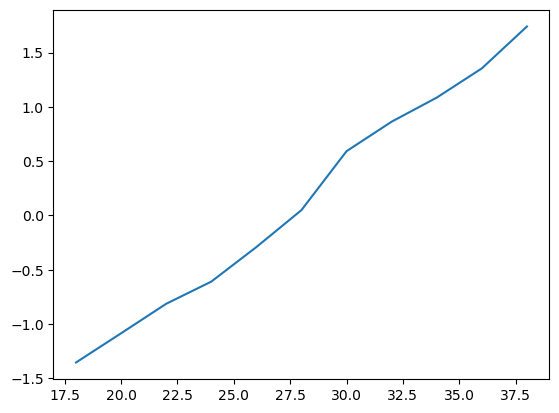

In [43]:
min_max_scaler = MinMaxScaler(feature_range=(0,2))
scaled_data = min_max_scaler.fit_transform(mydata.reshape(-1,1)) #reshapes 1D array , to 2D array with 1 column (meant for dict's)
plt.plot(my_um,scipy.special.erfcinv(scaled_data))

In [42]:
mydata = np.array([1.46,1.42,1.37,1.28,1.18,0.97,0.7,0.31,0.18,0.11,0.06,0.03,0.02])
my_um = np.array([16,18,20,22,24,26,28,30,32,34,36,38,40])

## Simple matrix linear regression (fast!)

In [82]:
import numpy as np

# Example data
X = my_um[1:-1]  # Feature values
y = filtered_y  # Target values

# Convert 1D array to 2D array and add a column of ones
X = np.vstack([np.ones(len(X)), X]).T

# Calculate the coefficients using the normal equation: (X^T X)^-1 X^T y
# X^T X
X_transpose = X.T
X_transpose_X = np.dot(X_transpose, X)

# (X^T X)^-1
X_transpose_X_inv = np.linalg.inv(X_transpose_X)

# X^T y
X_transpose_y = np.dot(X_transpose, y)

# Coefficients
coefficients = np.dot(X_transpose_X_inv, X_transpose_y)

print("Coefficients:", coefficients) #intercept, slope
print('Spotsize', np.sqrt(2)/coefficients[1])


Coefficients: [-4.28276292  0.15792263]
Spotsize 8.955104069147165


### Mask to remove inf/nan

In [78]:


# Create a boolean mask for valid (non-NaN and non-Inf) values
mask = np.isfinite(y)

# Apply the mask to filter out NaN and Inf values
filtered_y = y[mask]

print("Original y:", y)
print("Filtered y:", filtered_y)


Original y: [-1.35376005 -1.08478704 -0.81341985 -0.60926733 -0.2911195   0.04927468
  0.59161542  0.86312307  1.08478704  1.35376005  1.7395706 ]
Filtered y: [-1.35376005 -1.08478704 -0.81341985 -0.60926733 -0.2911195   0.04927468
  0.59161542  0.86312307  1.08478704  1.35376005  1.7395706 ]
